In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
data0 = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Scorecard_Project/Internal_test_0_datasetForMultivariateVSExceptIV.csv', index_col=[0])

In [3]:
data = data0.copy()
target = data['loan_status']
features = data.drop(columns=['loan_status'])

In [4]:
data0.describe()

,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,-0.010545,8.031905e+04,5.410333,13.108453,9583.157556,3.377905,11.006606,0.139725,5.867489,632.608756,429.320900,0.222222
std,1.616146,8.042250e+04,6.063532,68.924732,6314.886691,35.042764,2.978808,0.087212,3.879702,50.435865,526.746609,0.415744
min,-3.936107,8.000000e+03,0.000000,-56.596502,500.000000,-41.855848,5.420000,0.000000,2.000000,390.000000,-105.868637,0.000000
25%,-1.749761,4.720400e+04,1.000000,-51.724408,5000.000000,-29.945313,8.590000,0.070000,3.000000,601.000000,-105.868637,0.000000
50%,-0.522740,6.704800e+04,4.000000,-51.724408,8000.000000,12.453608,11.010000,0.120000,4.000000,640.000000,947.746253,0.000000
75%,1.090857,9.578925e+04,8.000000,77.828324,12237.250000,33.571609,12.990000,0.190000,8.000000,670.000000,947.746253,0.000000
max,2.657918,7.200766e+06,125.000000,125.418365,35000.000000,52.718578,20.000000,0.660000,30.000000,850.000000,947.746253,1.000000


In [5]:
def feature_reduce_rf(threshold, features, bad, test_size, max_depth):
    '''
    1) Train on a random forest classifier and compute the AUC on the same data;
    2) Drop features to keep top features that have threshold (eg: 0.99) feature importance
    3) Repeat 1) 2) until there's only one feature left
    4) Plot the AUC
    '''
    AUC_train = []
    AUC_test = []
    num_features = []

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, bad, test_size=test_size, random_state=42)

    while X_train.shape[1] > 1:
        # Define a random forest classifier
        fs_clf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, min_samples_split=2, min_samples_leaf=1, random_state=42)

        # Train the classifier
        fs_clf.fit(X_train, y_train)

        # Get the feature importance values
        importances = fs_clf.feature_importances_
        feature_names = X_train.columns # list of feature names

        # Sort the feature importances in descending order
        sorted_index = np.argsort(importances)[::-1]

        # Print the sorted feature importance values
        for i in sorted_index:
            print(f"Feature {feature_names[i]}: {importances[i]}")

        # Predict probabilities
        y_train_pred = fs_clf.predict_proba(X_train)[:, 1]
        y_test_pred = fs_clf.predict_proba(X_test)[:, 1]

        # Compute the AUC
        auc_train = roc_auc_score(y_train, y_train_pred)
        auc_test = roc_auc_score(y_test, y_test_pred)

        # Print number of features
        print('Number of Features: {}'.format(X_train.shape[1]))
        # Print the AUC
        print(f"AUC Train: {auc_train:.4f}")
        print(f"AUC Test: {auc_test:.4f}")

        # Record number of features, AUC
        num_features.append(X_train.shape[1])
        AUC_train.append(auc_train)
        AUC_test.append(auc_test)

        # Add up the feature importances until they reach the threshold
        num = 0
        cum_importance = 0.0
        for feature_index in sorted_index:
            cum_importance += importances[feature_index]
            num += 1
            if cum_importance >= threshold:
                break

        # If number of features no longer decrease, decrement 1
        if num_features[-1] == num:
            num -= 1

        # Select the top num features
        top_features = feature_names[sorted_index[:num]]
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    # Plot the AUC
    fig = plt.figure(figsize=(15,8))
    x = np.arange(len(num_features))
    plt.plot(x, AUC_train, label='Train AUC')
    plt.plot(x, AUC_test, label='Test AUC')
    plt.xticks(x, num_features, rotation=90, ha='right', fontsize=6)
    plt.xlabel('Number of Features')
    plt.ylabel('AUC')
    plt.title('AUC vs. Number of Features Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

Feature previous_loan_defaults_on_file: 0.391605774311947
Feature loan_percent_income: 0.2594676639608545
Feature loan_int_rate: 0.1646695949084568
Feature person_home_ownership: 0.08673893386361105
Feature person_income: 0.07486538778327735
Feature loan_intent: 0.01444019173786108
Feature loan_amnt: 0.006326892592494336
Feature credit_score: 0.0016461309591590124
Feature person_emp_exp: 0.0001569591523696722
Feature cb_person_cred_hist_length: 8.247072996935025e-05
Feature person_education: 0.0
Number of Features: 11
AUC Train: 0.9540
AUC Test: 0.9521
Feature previous_loan_defaults_on_file: 0.43827393675984727
Feature loan_percent_income: 0.2469191279699294
Feature loan_int_rate: 0.14386334166048464
Feature person_income: 0.09638881853196758
Feature person_home_ownership: 0.06741128364929175
Feature loan_intent: 0.007143491428479371
Number of Features: 6
AUC Train: 0.9536
AUC Test: 0.9528
Feature previous_loan_defaults_on_file: 0.463724928166832
Feature loan_percent_income: 0.27117045

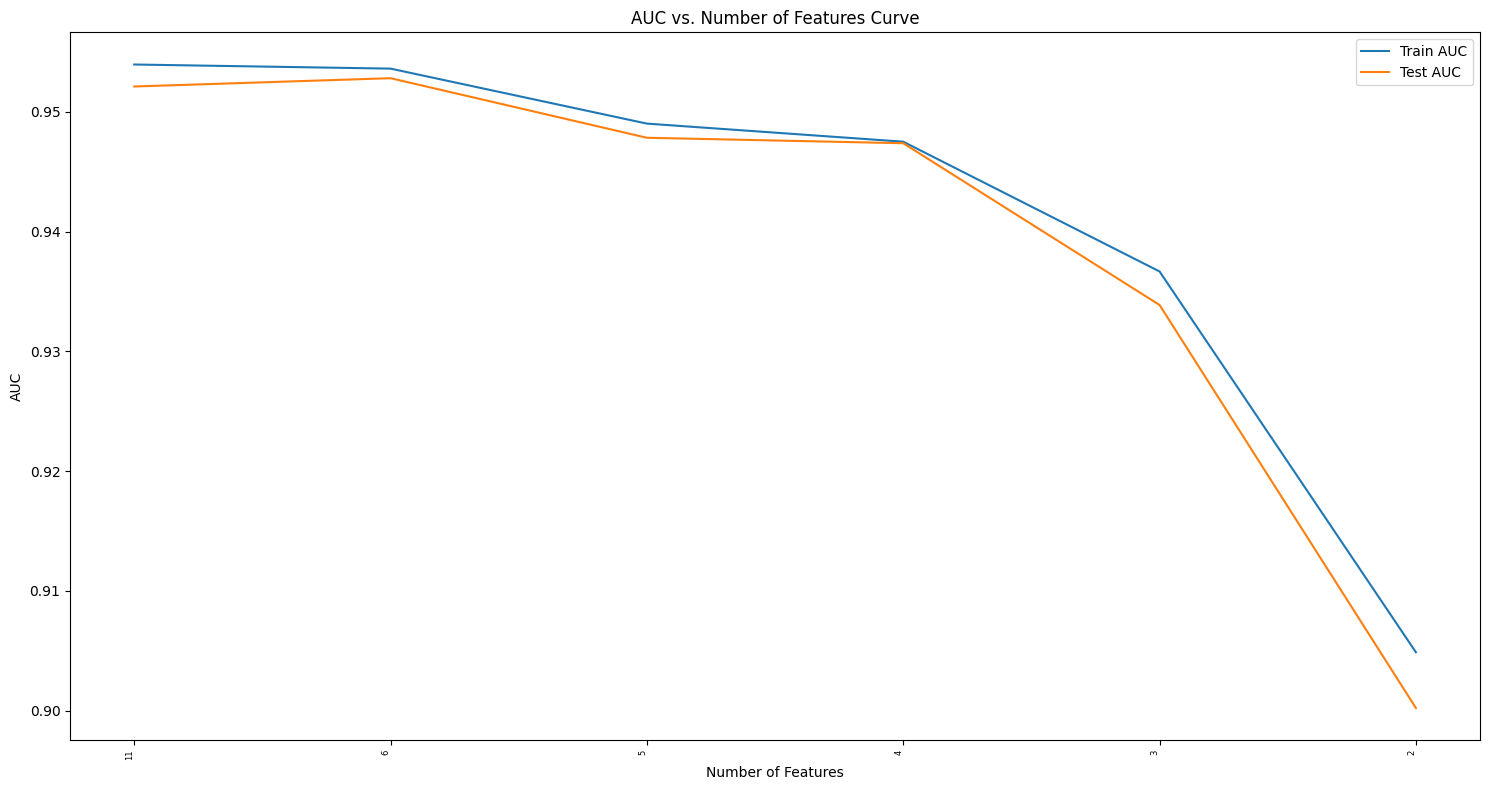

In [6]:
feature_reduce_rf(0.99, features, data['loan_status'],test_size=0.2, max_depth=2)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 5, 10, 12],
    'min_samples_leaf': [1, 2, 4, 6],
}

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='roc_auc',return_train_score=True)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print("Hyperparameters\t\t\t\t\t\t\t\t\t\t\t\t\t\tTrain AUC\t\tTest AUC")
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]
    avg_train_auc = grid_search.cv_results_['mean_train_score'][i]
    avg_test_auc = grid_search.cv_results_['mean_test_score'][i]
    print(f"{params}\t{avg_train_auc:.4f}\t\t{avg_test_auc:.4f}")

print("The best parameters are {}".format(grid_search.best_params_))
print("The mean ROC AUC of the best parameters is {}".format(grid_search.best_score_))


Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Hyperparameters														Train AUC		Test AUC
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}	0.9527		0.9524
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}	0.9538		0.9535
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}	0.9537		0.9534
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}	0.9544		0.9540
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}	0.9527		0.9524
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}	0.9538		0.9535
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}	0.9537		0.9534
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}	0.9544		0.9540
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samp

In [8]:
best_params

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [9]:
best_params_updated = {'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 400}

In [10]:
# Train the model with the best parameters
best_rf_clf = RandomForestClassifier(**best_params_updated, random_state=42)
best_rf_clf.fit(X_train, y_train)

y_train_pred = best_rf_clf.predict_proba(X_train)[:, 1]
y_test_pred = best_rf_clf.predict_proba(X_test)[:, 1]

# Compute the AUC
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test: {auc_test:.4f}")

importances = best_rf_clf.feature_importances_
feature_names = features.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': importances
})

feature_importances = feature_importances.sort_values(by='RF_Importance', ascending=False).reset_index(drop=True)
feature_importances['RF_Rank'] = feature_importances['RF_Importance'].rank(ascending=False).astype(int)

AUC Train: 0.9545
AUC Test: 0.9529


                           Feature  RF_Importance  RF_Rank
0   previous_loan_defaults_on_file       0.392178        1
1              loan_percent_income       0.248730        2
2                    loan_int_rate       0.166056        3
3            person_home_ownership       0.083000        4
4                    person_income       0.080787        5
5                      loan_intent       0.016473        6
6                        loan_amnt       0.010685        7
7                     credit_score       0.001710        8
8                   person_emp_exp       0.000321        9
9       cb_person_cred_hist_length       0.000062       10
10                person_education       0.000000       11


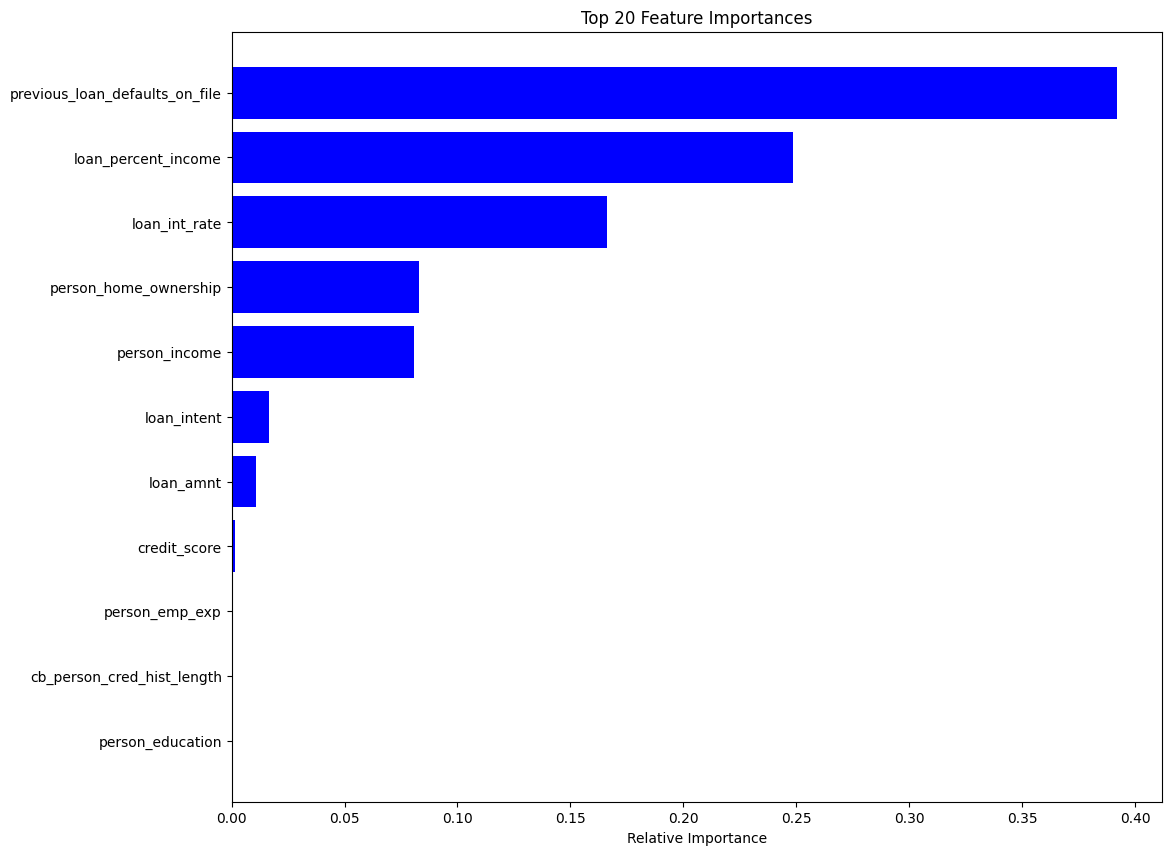

In [11]:
top_features = feature_importances.head(20)
print(top_features)

plt.figure(figsize=(12, 10))
plt.title("Top 20 Feature Importances")
plt.barh(top_features['Feature'], top_features['RF_Importance'], color='b', align='center')
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

In [12]:
feature_importances

,Feature,RF_Importance,RF_Rank
0,previous_loan_defaults_on_file,0.392178,1
1,loan_percent_income,0.248730,2
2,loan_int_rate,0.166056,3
3,person_home_ownership,0.083000,4
4,person_income,0.080787,5
5,loan_intent,0.016473,6
6,loan_amnt,0.010685,7
7,credit_score,0.001710,8
8,person_emp_exp,0.000321,9
9,cb_person_cred_hist_length,0.000062,10


In [13]:
feature_importances.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Scorecard_Project/Internal_Random Forest.csv')